In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from os import listdir
from os.path import isfile, join
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [3]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
G1020_DIR = 'archive/G1020/'
G1020_df = pd.read_csv(f'{G1020_DIR}G1020.csv')
G1020_df.head()

x = G1020_df['imageID']
y = G1020_df['binaryLabels']

x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.8)
x_test, x_val, y_test, y_val = train_test_split(x_rem, y_rem, train_size = 0.5)


In [5]:
source_folder = 'archive/G1020/Images_Square/'
train_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/train/'
test_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/test/'
val_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/val/'

for img in x_train:
    source_path = source_folder + img
    shutil.copy(source_path, train_destination_path)

for img in x_test:
    source_path = source_folder + img
    shutil.copy(source_path, test_destination_path)

for img in x_val:
    source_path = source_folder + img
    shutil.copy(source_path, val_destination_path)

In [6]:
G1020_df_train = pd.DataFrame()
G1020_df_train['image'] = x_train
G1020_df_train['label'] = y_train

train_source_folder = 'archive/G1020/Images_Square_Train_Test_Val_Split/train/'
negative_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/train/0'
positive_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/train/1'

for index, row in G1020_df_train.iterrows():
    image = row['image']
    label = row['label']

    source_path = train_source_folder + image

    if label == 0:
        shutil.move(source_path, negative_destination_path)
    elif label == 1:
        shutil.move(source_path, positive_destination_path)



Error: Destination path 'archive/G1020/Images_Square_Train_Test_Val_Split/train/0\image_444.jpg' already exists

In [ ]:
val_source_folder = 'archive/G1020/Images_Square_Train_Test_Val_Split/val/'
val_negative_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/val/0'
val_positive_destination_path = 'archive/G1020/Images_Square_Train_Test_Val_Split/val/1'

G1020_df_val = pd.DataFrame()
G1020_df_val['image'] = x_val
G1020_df_val['label'] = y_val

for index, row in G1020_df_val.iterrows():
    image = row['image']
    label = row['label']

    source_path = val_source_folder + image

    if label == 0:
        shutil.move(source_path, val_negative_destination_path)
    elif label == 1:
        shutil.move(source_path, val_positive_destination_path)

In [7]:
train_set = datasets.ImageFolder('archive/G1020/Images_Square_Train_Test_Val_Split/train', transform = transformations)
val_set = datasets.ImageFolder('archive/G1020/Images_Square_Train_Test_Val_Split/val', transform = transformations)
# test_set = datasets.ImageFolder('archive/G1020/Images_Square_Train_Test_Val_Split/test', transform = transformations)

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32, shuffle = True)

In [9]:
model = models.densenet161(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

c:\Users\Josiah Foo\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josiah Foo\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
classifier_input = model.classifier.in_features
num_labels = 2

classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))

model.classifier = classifier

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters())

In [13]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26
1 / 4
2 / 4
3 / 4
4 / 4
Accuracy:  0.6927083283662796
Epoch: 0 	Training Loss: 0.613303 	Validation Loss: 0.651497
1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26
1 / 4
2 / 4
3 / 4
4 / 4
Accuracy:  0.7265625
Epoch: 1 	Training Loss: 0.600035 	Validation Loss: 0.709469
1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26
1 / 4
2 / 4
3 / 4
4 / 4
Accuracy:  0.6588541716337204
Epoch: 2 	Training Loss: 0.611939 	Validation Loss: 0.646424
1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 /

In [14]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [16]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [17]:
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model is  70.39616107940674 % certain that the image has a predicted class of  0


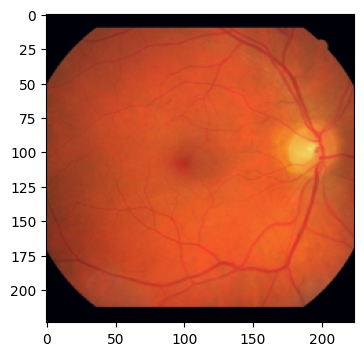

In [29]:
# Process Image
image = process_image("archive/G1020/Images_Square_Train_Test_Val_Split/test/image_232.jpg")
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
show_image(image)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class)

In [51]:
G1020_df_test = pd.DataFrame()
G1020_df_test['imageName'] = x_test
G1020_df_test['binaryLabel'] = y_test

test_dictionary = G1020_df_test.set_index('imageName').T.to_dict('list')
print(test_dictionary)
print(len(test_dictionary))

accuracy = 0
total_count = len(test_dictionary)

path = 'archive/G1020/Images_Square_Train_Test_Val_Split/test/'
imagefiles = [f for f in listdir(path) if isfile(join(path, f))]
print(len(imagefiles))

for image in imagefiles:
    image_path = path + image
    img = process_image(image_path)
    top_prob, top_class = predict(img, model)
    if image not in test_dictionary:
        continue
    else: 
        correct_class = test_dictionary[image][0]
        print(image)
        # print(correct_class)
        # print(top_class)

        if top_class == correct_class:
            accuracy = accuracy + 1

accuracy_percentage = accuracy / total_count
print(accuracy_percentage)

{'image_2766.jpg': [0], 'image_519.jpg': [0], 'image_980.jpg': [0], 'image_1137.jpg': [0], 'image_2906.jpg': [0], 'image_1190.jpg': [0], 'image_304.jpg': [0], 'image_1592.jpg': [1], 'image_50.jpg': [0], 'image_1897.jpg': [1], 'image_3168.jpg': [1], 'image_566.jpg': [0], 'image_1607.jpg': [1], 'image_56.jpg': [0], 'image_1714.jpg': [1], 'image_144.jpg': [0], 'image_3019.jpg': [0], 'image_571.jpg': [0], 'image_2513.jpg': [0], 'image_2173.jpg': [0], 'image_2276.jpg': [1], 'image_215.jpg': [0], 'image_2504.jpg': [0], 'image_2711.jpg': [0], 'image_2039.jpg': [0], 'image_1722.jpg': [0], 'image_610.jpg': [0], 'image_21.jpg': [0], 'image_295.jpg': [0], 'image_780.jpg': [1], 'image_2209.jpg': [0], 'image_958.jpg': [0], 'image_2687.jpg': [0], 'image_483.jpg': [0], 'image_2022.jpg': [0], 'image_1961.jpg': [0], 'image_3131.jpg': [0], 'image_2001.jpg': [1], 'image_2562.jpg': [1], 'image_1386.jpg': [0], 'image_1164.jpg': [0], 'image_542.jpg': [0], 'image_2856.jpg': [0], 'image_903.jpg': [1], 'image_

In [41]:
G1020_df_test

,imageName,binaryLabel
877,image_2766.jpg,0
165,image_519.jpg,0
304,image_980.jpg,0
329,image_1137.jpg,0
922,image_2906.jpg,0
...,...,...
5,image_6.jpg,0
128,image_387.jpg,1
180,image_561.jpg,0
6,image_9.jpg,0
